In [31]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

In [62]:
DATA_DIR = 'WarpDoc'
DIGITAL = os.path.join(DATA_DIR, 'digital')
DISTORTED = os.path.join(DATA_DIR, 'distorted')
TARGET_WIDTH = 512

In [63]:
processed_images = {}
ground_truth = {}

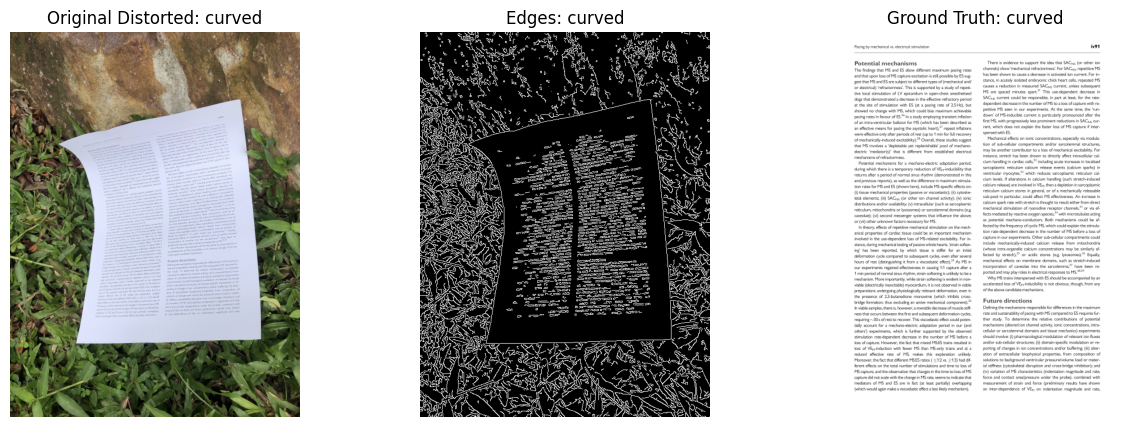

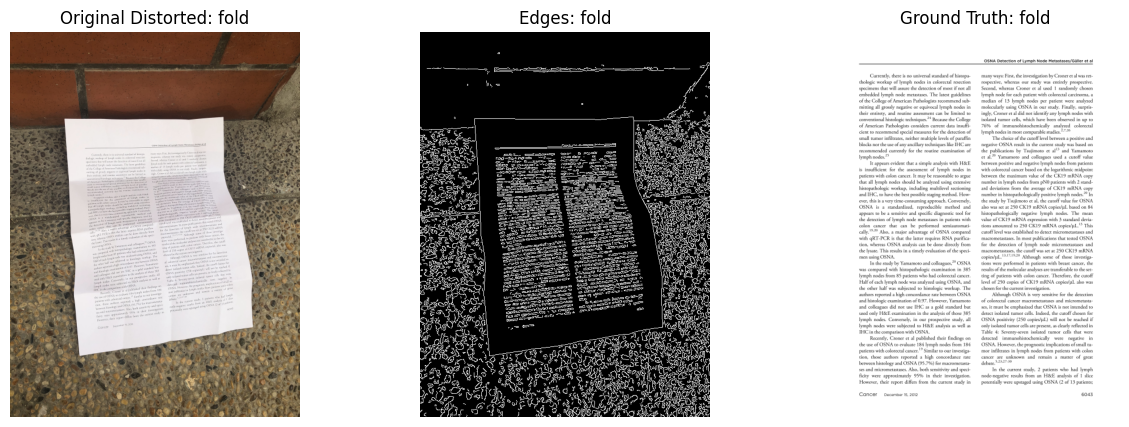

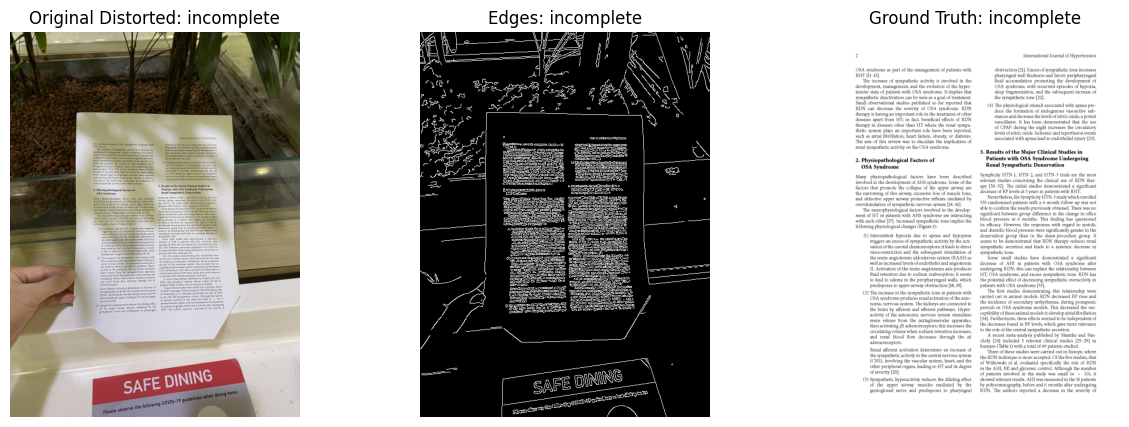

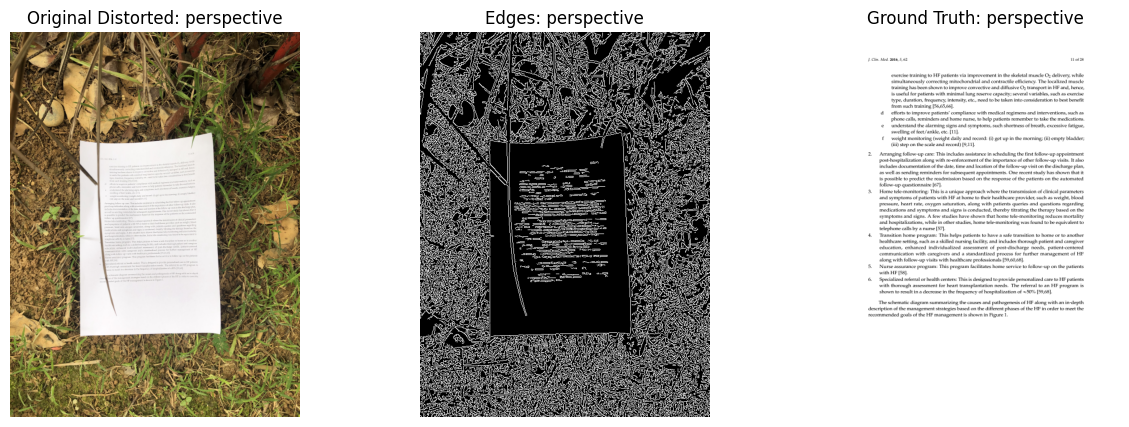

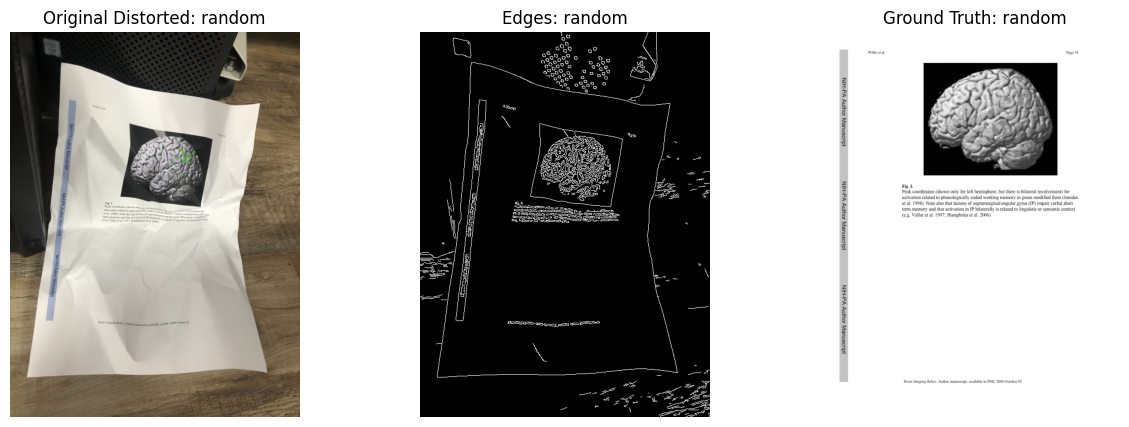

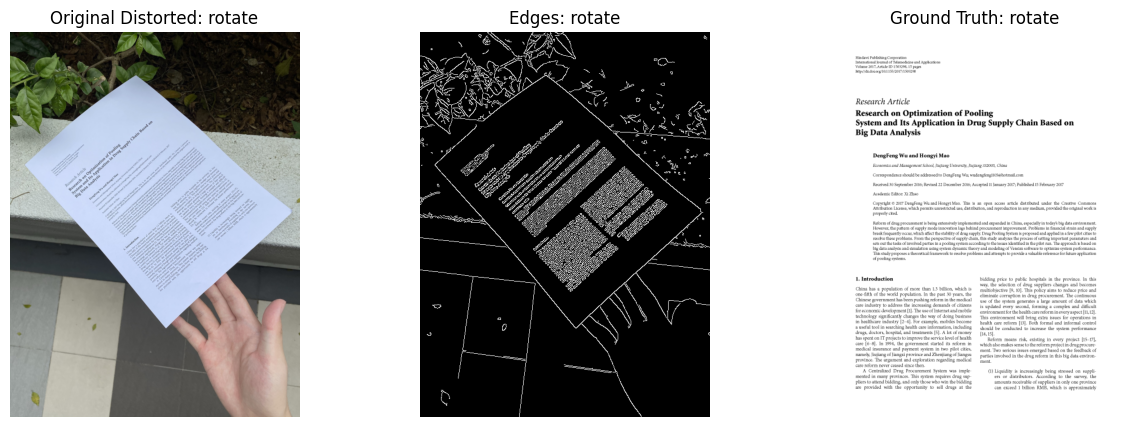

In [64]:
# reading and processing images
for category in os.listdir(DIGITAL):
    digital_category = os.path.join(DIGITAL, category)
    distorted_category = os.path.join(DISTORTED, category)

    digital_paths = glob.glob(os.path.join(digital_category, "*.jpg"))  
    distorted_paths = glob.glob(os.path.join(distorted_category, "*.jpg"))

    # init
    processed_images[category] = []
    ground_truth[category] = []

    for dig_path, dist_path in zip(sorted(digital_paths), sorted(distorted_paths)):
        dig_image = cv2.imread(dig_path)
        dist_image = cv2.imread(dist_path)

        scale = TARGET_WIDTH / dist_image.shape[1]  # Resize width
        new_size = (TARGET_WIDTH, int(dist_image.shape[0] * scale))

        dig_image = cv2.resize(dig_image, new_size, interpolation=cv2.INTER_AREA)
        dist_image = cv2.resize(dist_image, new_size, interpolation=cv2.INTER_AREA)

        # convert to grayscale
        dig_gray = cv2.cvtColor(dig_image, cv2.COLOR_BGR2GRAY)
        dist_gray = cv2.cvtColor(dist_image, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(dist_gray, 100, 200)

        ground_truth[category].append(dig_gray)
        processed_images[category].append(edges)

        # to visualize one for each category
        if len(processed_images[category]) == 1:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(dist_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Original Distorted: {category}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(edges, cmap='gray')
            plt.title(f'Edges: {category}')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(dig_gray, cmap='gray')
            plt.title(f'Ground Truth: {category}')
            plt.axis('off')

            plt.show()

In [55]:
def hough_transform(edges, theta_res=1, rho_res=1):
    h, w = edges.shape

    # theta range (-90 to 90 degrees)
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))

    diag_len = int(np.sqrt(h**2 + w**2))  # max possible rho
    rhos = np.arange(-diag_len, diag_len, rho_res)

    votes = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    edge_pixels = np.argwhere(edges) # (y, x)

    # voting
    for y, x in edge_pixels:
        for theta_idx, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.argmin(np.abs(rhos - rho))  # closest rho index

            votes[rho_idx, theta_idx] += 1

    return votes, thetas, rhos

In [67]:
votes, thetas, rhos = {}, {}, {}

In [ ]:
for category in processed_images: # 470 mins
    votes[category] = []
    thetas[category] = []
    rhos[category] = []

    for edges in processed_images[category]:
        v, t, r = hough_transform(edges)
        votes[category].append(v)
        thetas[category].append(t)
        rhos[category].append(r)

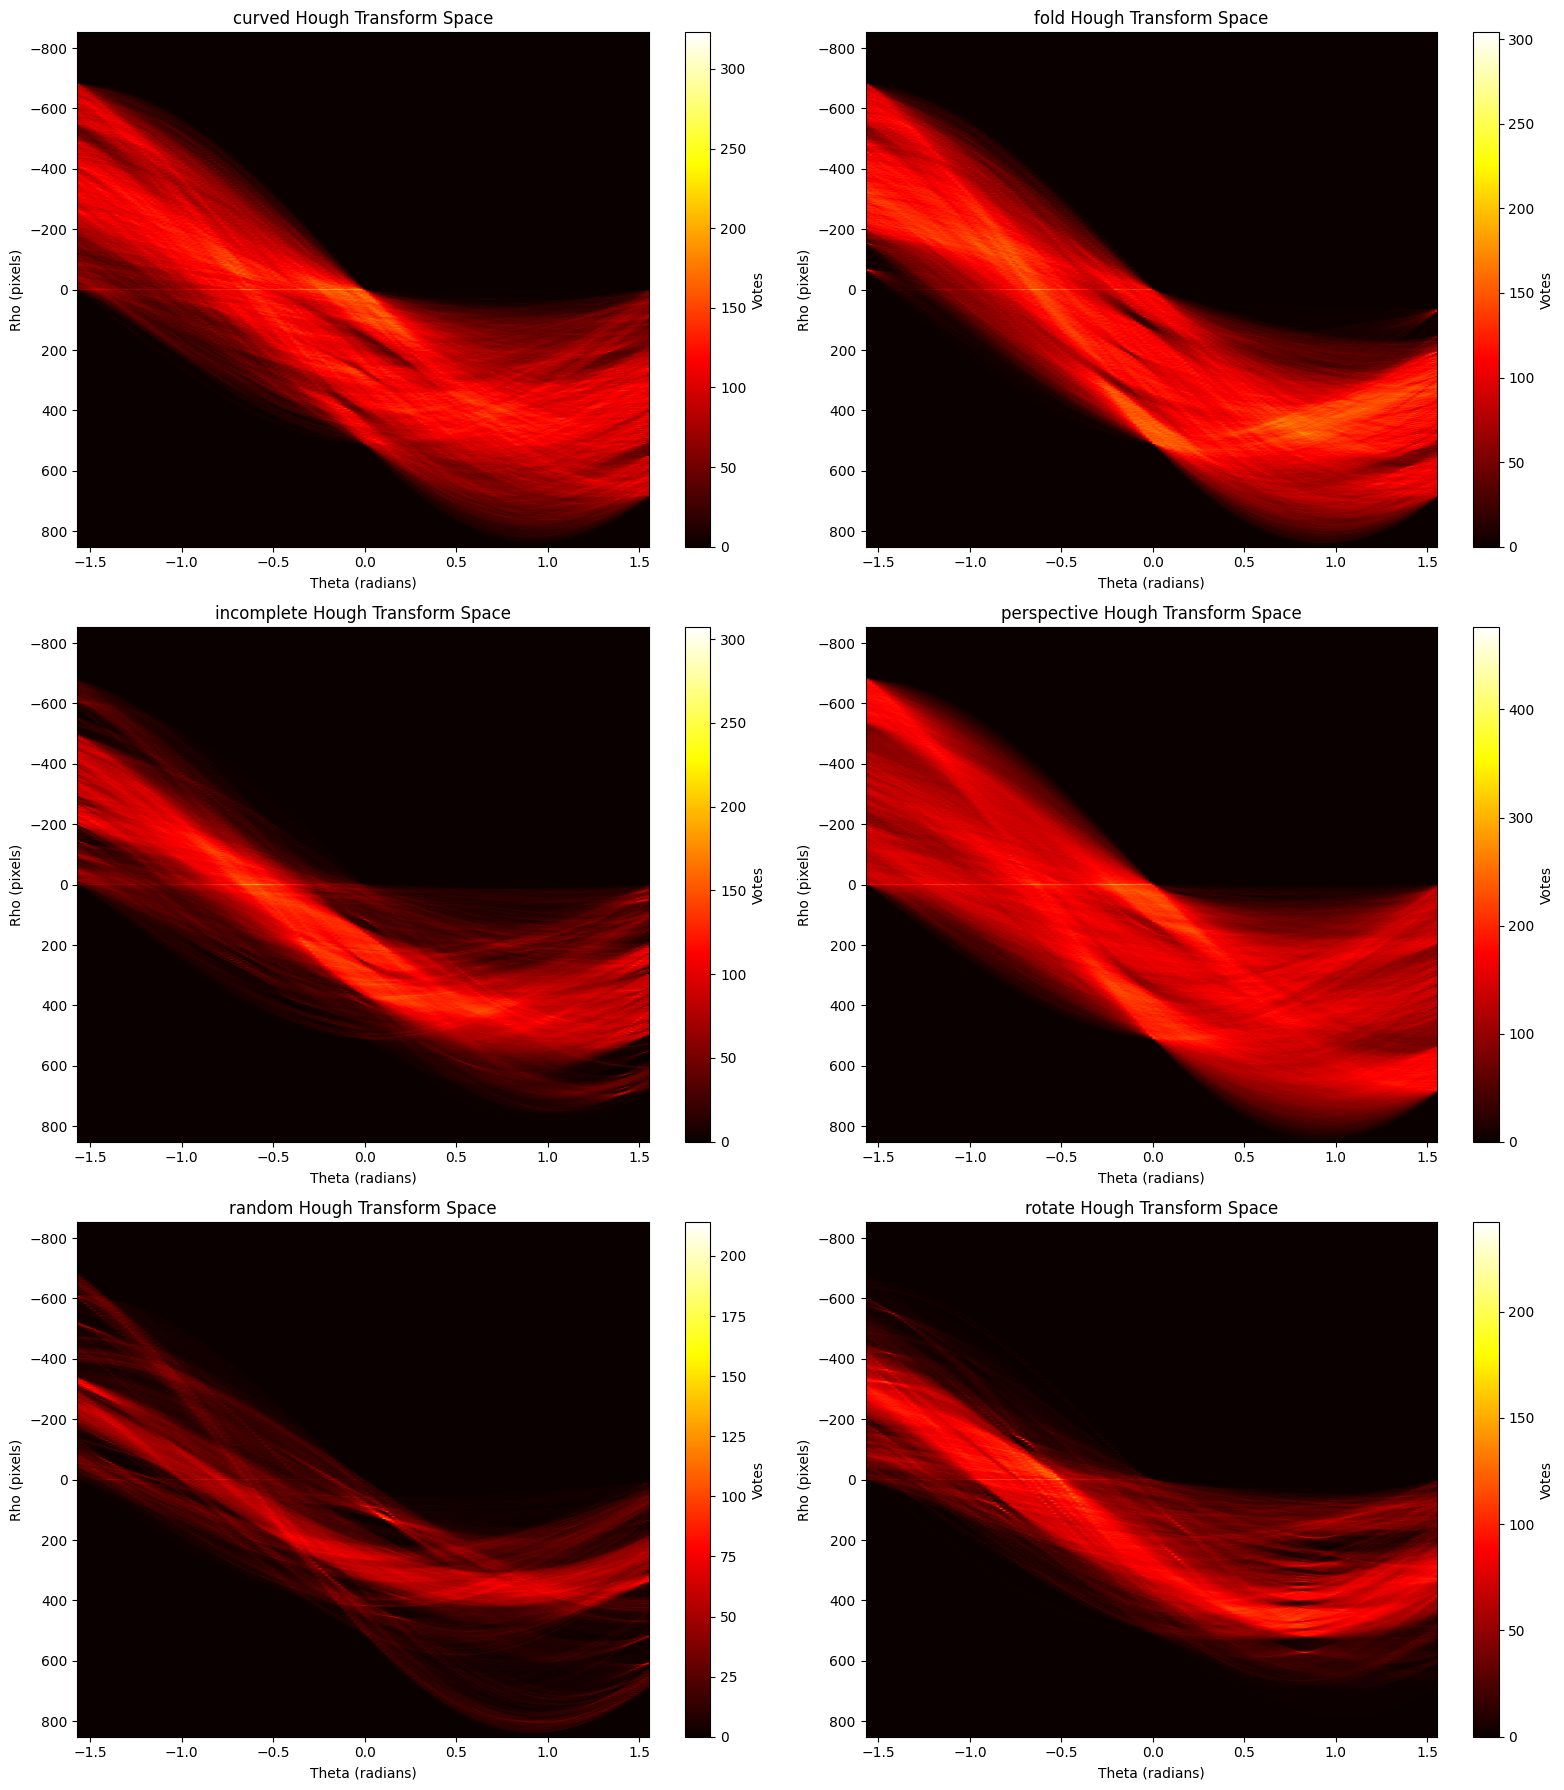

In [74]:
plt.figure(figsize=(16, 18))

for i, category in enumerate(processed_images):
    plt.subplot(3, 2, i+1)
    vote, theta, rho = votes[category][0], thetas[category][0], rhos[category][0]
    plt.imshow(vote, cmap='hot', aspect='auto', extent=[theta[0], theta[-1], rho[-1], rho[0]])
    plt.title(f"{category} Hough Transform Space")
    plt.xlabel("Theta (radians)")
    plt.ylabel("Rho (pixels)")
    plt.colorbar(label="Votes")

plt.tight_layout()
plt.show()